In [1]:
import heapq
import numpy as np
from icecream import ic
from random import choice
from tqdm.auto import tqdm
from collections import namedtuple
from matplotlib import pyplot as plt

### Problem Setup and Helper Functions

The dimension of the puzzle and a named tuple used to represent a move between two positions (`pos1` and `pos2`) are defined.

In [2]:
PUZZLE_DIM = 4
Action = namedtuple('Action', ['pos1', 'pos2'])

The correct positions of each tile are calculated and stored in a dictionary with the number as key and the target coordinates as value.

In [3]:
def get_correct_pos():
    # row: (n-1) // PUZZLE_DIM, column: n - PUZZLE_DIM * row - 1
    correct_pos = {n : ((n-1) // PUZZLE_DIM, n - PUZZLE_DIM * ((n-1) // PUZZLE_DIM) - 1) for n in range(1, PUZZLE_DIM**2)}
    correct_pos[0] = (PUZZLE_DIM-1, PUZZLE_DIM-1)
    return correct_pos

CORRECT_POS = get_correct_pos()

The `available_actions` function returns a list of all possible moves (`Action`) that can be made from the current puzzle state. The `do_action` function takes the current puzzle state and an action and returns the new state obtained after the action is performed. It swaps the empty tile with the tile specified by the action.

In [4]:
def available_actions(state: np.ndarray) -> list['Action']:
    x_start, y_start = [int(_[0]) for _ in np.where(state == 0)]
    actions = list()
    if x_start > 0:
        actions.append(Action((x_start, y_start), (x_start-1, y_start)))
    if x_start < PUZZLE_DIM - 1:
        actions.append(Action((x_start, y_start), (x_start+1, y_start)))
    if y_start > 0:
        actions.append(Action((x_start, y_start), (x_start, y_start-1)))
    if y_start < PUZZLE_DIM - 1:
        actions.append(Action((x_start, y_start), (x_start, y_start+1)))
    return actions

def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state


### Heuristics

Different heuristics are defined.

In [5]:
def hamming_distance(state: np.ndarray) -> int:
    wrong_positions = 0
    for n in range(1, PUZZLE_DIM**2):
        x_current, y_current = [int(_[0]) for _ in np.where(state == n)]
        if x_current != CORRECT_POS[n][0] or y_current != CORRECT_POS[n][1]:
            wrong_positions += 1
    return wrong_positions

def manhattan_distance(state: np.ndarray) -> int:
    total_distance = 0
    for n in range(1, PUZZLE_DIM**2):
        x_current, y_current = [int(_[0]) for _ in np.where(state == n)]
        total_distance += abs(x_current - CORRECT_POS[n][0]) + abs(y_current - CORRECT_POS[n][1])
    return total_distance

def n_linear_conflicts(state: np.ndarray) -> int:
    conflicts = 0

    # row conflicts
    for r in range(PUZZLE_DIM):
        for c in range(PUZZLE_DIM):
            for k in range(c+1, PUZZLE_DIM):
                if(state[r][c] and state[r][k] and CORRECT_POS[state[r][c]][0] == r and 
                CORRECT_POS[state[r][k]][0] == r and CORRECT_POS[state[r][c]][1] > CORRECT_POS[state[r][k]][1]):
                    conflicts += 1
    # column conflicts
    for c in range(PUZZLE_DIM):
        for r in range(PUZZLE_DIM):
            for l in range(r+1, PUZZLE_DIM):
                if(state[r][c] and state[l][c] and CORRECT_POS[state[r][c]][1] == c and 
                CORRECT_POS[state[l][c]][1] == c and CORRECT_POS[state[r][c]][0] > CORRECT_POS[state[l][c]][0]):
                    conflicts += 1

    return conflicts

def linear_conflicts_distance(state: np.ndarray) -> int:
    return manhattan_distance(state) + 2*n_linear_conflicts(state)

A precise heuristic is chosen. If you want to use a different heuristic than the one proposed, simply modify the following line of code. It is not recommended to use the Hamming distance for problems larger than 8-puzzle. It does not converge in a feasible amount of time.

In [6]:
heuristic = linear_conflicts_distance

The goal state and initial state are defined. The `initial_state` is obtained applying a sequence of random actions to shuffle the goal state. The `RANDOMIZE_STEPS` constant defines the number of random moves to apply.

In [7]:
RANDOMIZE_STEPS = 1_000
GOAL_STATE = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
print(GOAL_STATE)

initial_state = GOAL_STATE.copy()
for step in range(RANDOMIZE_STEPS): # use tqdm
    initial_state = do_action(initial_state, choice(available_actions(initial_state)))
    
h_distance = heuristic(initial_state)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15  0]]


### Node class

In [8]:
class Node:
    def __init__(self, state: np.ndarray, parent, g: int, h: int) -> None:
        self.state = state
        self.parent = parent
        self.g = g
        self.h = h

    def __lt__(self, next):
        return self.g + self.h < next.g + next.h

### A* algorithm

The A* (pronounced as "A star") algorithm is used to find the **shortest path** between the starting node (the initial configuration of the puzzle) and the goal node (the puzzle solved with all the tiles in the correct positions). It uses a heuristic function to help decide which path to follow next.

In [9]:
frontier = []
explored = set()
n_actions = 0
heapq.heappush(frontier, Node(initial_state, None, 0, h_distance))

heuristics_history = []

while frontier:
    n_actions += 1
    current_node = heapq.heappop(frontier)
    heuristics_history.append(current_node.h)

    # puzzle solved
    if np.array_equal(current_node.state, GOAL_STATE):
        path = []
        node = current_node
        while node.parent != None:
            path.append(node.state)
            node = node.parent
        path.append(initial_state)
        print(path[::-1])
        break

    # Explore neighbors of the current state if the puzzle is not solved yet
    for action in available_actions(current_node.state):
        new_state = do_action(current_node.state, action)
        if tuple(new_state.flatten()) not in explored:
            explored.add(tuple(new_state.flatten()))
            heuristic_distance = heuristic(new_state)
            heapq.heappush(frontier, Node(new_state, current_node, current_node.g + 1, heuristic_distance))

print(f"\nSolve {PUZZLE_DIM*PUZZLE_DIM-1}-puzzle in {len(path)} moves")
print(f"{n_actions} evaluated actions")


[array([[ 0, 10, 14,  8],
       [15, 11,  3,  9],
       [ 7, 12,  2,  6],
       [ 4,  5,  1, 13]]), array([[10,  0, 14,  8],
       [15, 11,  3,  9],
       [ 7, 12,  2,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  0,  8],
       [15, 11,  3,  9],
       [ 7, 12,  2,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15, 11,  0,  9],
       [ 7, 12,  2,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15, 11,  2,  9],
       [ 7, 12,  0,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15, 11,  2,  9],
       [ 7,  0, 12,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15,  0,  2,  9],
       [ 7, 11, 12,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15,  2,  0,  9],
       [ 7, 11, 12,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15,  2,  9,  0],
       [ 7, 11, 12,  6],
       [ 4,  5,  1, 13]]), array([[10, 14,  3,  8],
       [15,  2,  9,  6],
       [ 7, 11, 12,  0],
      

### Plots

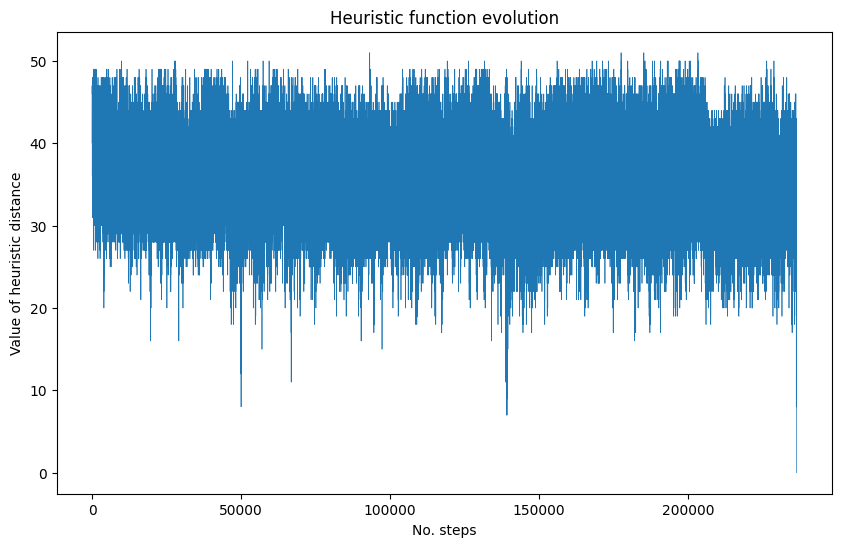

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(heuristics_history, linewidth = 0.5)
plt.xlabel("No. steps")
plt.ylabel("Value of heuristic distance")
plt.title("Heuristic function evolution")

plt.savefig("plots/15-puzzle_heuristic.png", dpi=300)

plt.show()